In [126]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [127]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [128]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [129]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [130]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [131]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [132]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [133]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [136]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)


('2017-08-23',)


In [273]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = most_recent_date[0]

# Calculate the date one year from the last date in data set.
year_later = pd.to_datetime(recent_date) - dt.timedelta(days=365)

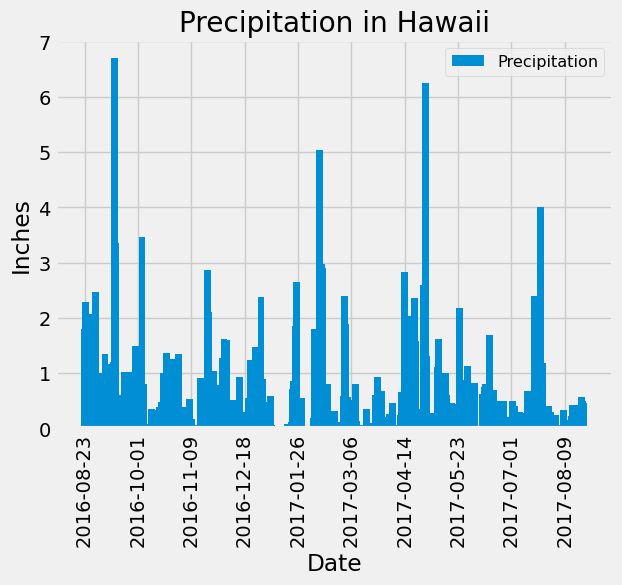

In [276]:


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_later.date()).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
sort_precip_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(sort_precip_df.index, sort_precip_df['Precipitation'], width=5, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation in Hawaii')
plt.xticks(np.arange(0, 365, 39),rotation=90)
plt.legend(fontsize='small')
plt.show()


In [277]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df[['Precipitation']].describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [278]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Measurement.station).distinct(Measurement.station).count()
total_stations


9

In [279]:
results = session.query(Measurement.station, Measurement.prcp).filter(Measurement.date >= year_later.date()).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

In [280]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_results = session.query((Measurement.station), func.count(Measurement.station)).group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()
station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [281]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)). \
    filter(Measurement.station == station_results[0][0]).all()
most_active_stats

[(54.0, 85.0, 71.66378066378067)]

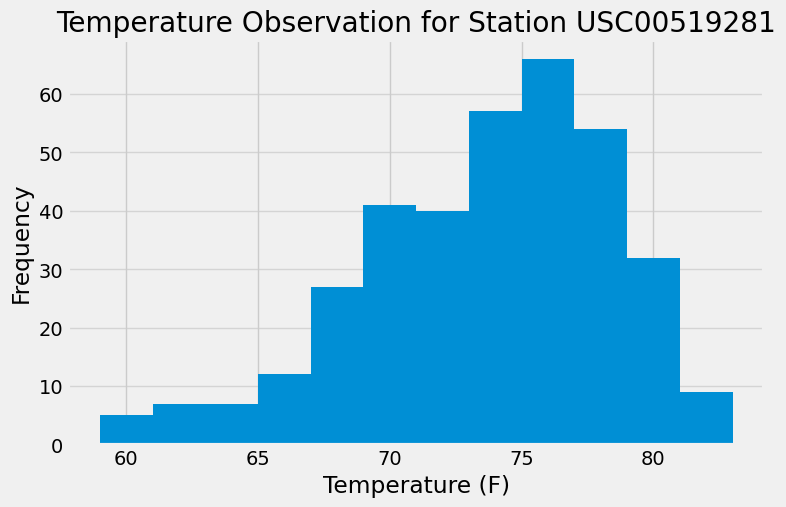

In [283]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).filter(Measurement.station == station_results[0][0]).first()

most_active_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == station_results[0][0]).\
        filter(Measurement.date >= func.date((max_date[0]), '-12 months')).all()


# Save the query results to a Pandas DataFrame
temp_df = pd.DataFrame(most_active_temps, columns=['date', 'tobs'])

# Plot the results as a histogram
plt.figure(figsize=(8, 5))
plt.hist(temp_df['tobs'], bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation for Station {station_results[0][0]}')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()